In [23]:
def solve_optimization(gainF, risk, cost, alpha, Q):
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost

    risk = risk.clip(min=0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")

    utils = cp.multiply(cp.multiply(gainF, risk), d)
    constraints = [d >= 0, cp.sum(cost * d) <= Q]

    if alpha == 'inf':
        t = cp.Variable()
        objective = cp.Maximize(t)
        constraints.append(utils >= t)
    elif alpha == 1:
        objective = cp.Maximize(cp.sum(cp.log(utils)))
    elif alpha == 0:
        objective = cp.Maximize(cp.sum(utils))
    else:
        objective = cp.Maximize(cp.sum(utils**(1-alpha)) / (1-alpha))

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status != 'optimal':
        print(f"Warning: Problem status is {problem.status}")

    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)

    return optimal_decision, optimal_value



def solve_closed_form(g, r, c, alpha, Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c

    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
        
    sol, obj = d_star_closed, AlphaFairness(d_star_closed*g*r, alpha)

    return sol, obj
def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 1:
        S = np.sum(c / (r * g))

    if alpha == 0:
        # Utilitarian case: Allocate everything to the individual with the highest ratio
        ratios = (r * g) / c
        i_star = np.argmax(ratios)
        # Gradient is Q * g_i / c_i at the allocated index, zero elsewhere
        gradient[i_star, i_star] = Q * g[i_star] / c[i_star]
        return gradient

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star, _ = solve_closed_form(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

import torch
def AlphaFairness(util, alpha):
    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha) / (1-alpha))

In [45]:
import cvxpy as cp
import numpy as np

n = 5
x = cp.Variable(n)

g = np.array([1, 2, 3, 4, 5])
r = np.array([1, 2, 3, 4, 5])
p = cp.Parameter(n, nonneg=True)
a = 1.5
c = np.array([1, 2, 3, 4, 5])
Q = 10

obj = cp.Maximize((1/(1-a))*cp.sum(cp.power(cp.multiply(p,x), 1-a)))
constr = [cp.sum(cp.multiply(c,x)) <= Q, x >= 0]
problem = cp.Problem(obj, constr)

p.value = g * r
print(p.value.shape)
problem.solve(verbose=False)
print(x.value)


(5,)
[2.70128541 1.07200704 0.62433001 0.42545336 0.31597941]


In [25]:
sols = solve_closed_form(g, r, c, alpha=a, Q=Q)[0]
grad = compute_gradient_closed_form(g, r, c, alpha=a, Q=Q)
solver_sols = solve_optimization(torch.tensor(g), torch.tensor(r), torch.tensor(c), alpha=a, Q=Q)[0]

/Users/dennis/opt/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/expressions/expression.py:667: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [26]:
import torch
from cvxpylayers.torch import CvxpyLayer

# Create a cvxpylayer with the current cvxpy problem.
cvxpylayer = CvxpyLayer(problem, parameters=[p], variables=[x])
assert problem.is_dpp()

# Create a torch tensor for the parameter p.
p_torch = torch.tensor(p.value, dtype=torch.float32, requires_grad=True)

# Solve the problem.
solution, = cvxpylayer(p_torch)

print('solution', solution.requires_grad)

# Use the solution to compute a loss and perform backpropagation.
loss = solution.sum()
gradP = torch.autograd.grad(loss, p_torch, retain_graph=True, create_graph=True)[0]

print("Optimal x:", solution)
print("Gradient of p:", gradP)


solution True
Optimal x: tensor([2.7014, 1.0720, 0.6243, 0.4254, 0.3159],
       grad_fn=<_CvxpyLayerFnFnBackward>)
Gradient of p: tensor([-0.4377,  0.0025,  0.0125,  0.0094,  0.0066])


In [27]:
grad_l_d = (r * g) ** (1 - a) * r ** (-a)
finalgrad = grad_l_d @ grad

In [28]:
finalgrad, gradP.detach().cpu().numpy()

(array([-0.74641332,  0.27620768,  0.20646886,  0.14977072,  0.11396606]),
 array([-0.4376589 ,  0.00248973,  0.01252765,  0.00935546,  0.00661193],
       dtype=float32))

In [29]:
import matplotlib.pyplot as plt

def plot_gradients(analytical, numerical, title="Gradient Comparison"):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(analytical, cmap='viridis', interpolation='none')
    plt.title('Analytical Gradient')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(numerical, cmap='viridis', interpolation='none')
    plt.title('CVXPY grad')
    plt.colorbar()
    
    plt.suptitle(title)
    plt.show()

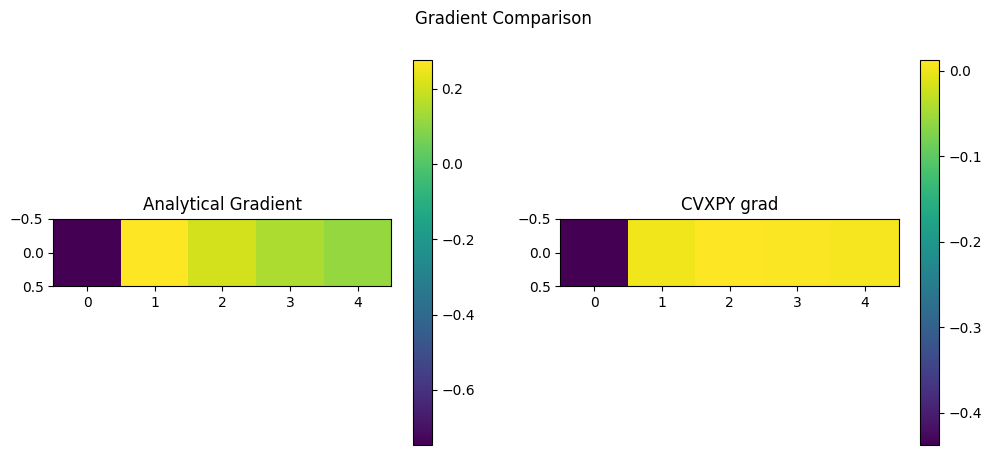

In [30]:
plot_gradients(finalgrad.reshape(1, -1), gradP.detach().cpu().numpy().reshape(1, -1), title="Gradient Comparison")

In [31]:
testarr = np.zeros((10, 1))
print(testarr)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [44]:
testarr.flatten().reshape(1,-1)[0].shape

(10,)